# Perceptron wielowarstwowy - klasyfikacja obrazów z ręcznie napisanymi cyframi (zbiór MNIST)

autor: Paulina Tomaszewska


Od tych zajęć będziemy pisać kod do tworzenia i trenowania modeli opartych na sieciach neuronowych w pakiecie (*framework*'u) Pytorch.
Nie jest to jedyny pakiet, ale najpopularniejszy i to jego znajomość wymagana jest na Polskiej i Międzynarodowej Olimpiadzie AI.
Alternatywne pakiety to m.in. Tensorflow, Keras, JAX.

### Import pakietów

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

### Ustawienie ziarna losowości

In [18]:
import numpy as np
import random

# Ustawiamy ziarno losowości, aby zapewność reprodukowalność (powtarzalność wyników)
# Ziarno losowości jest kluczowe np. podczas inicjalizacji wag
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

### Przygotowanie danych

In [19]:
# Ustaw na jakim urządzeniu mają być prowadzone obliczenia
# Jeżeli GPU nie jest dostępne, będzie to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Można zdefiniować ciąg transformacji danych wejściowych do modelu (więcej o tym w kolejnym notebook'u)
# Tutaj konwertujemy dane do tensora a następnie normalizujemy zgodnie ze wzorem (x-mean)/std
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Ładowanie zbioru danych MNIST (jako popularny zbiór danych dostępny jest w Pytorch)
dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Zgodnie z powyższą komórką oddzielnie pobraliśmy dane treningowe i testowe
# Nie mamy jednak danych walidacyjnych więc musimy je wydzielić np. ze zbioru treningowego
train_size = int(0.8 * len(dataset))  # 80% próbek z początkowego zbioru treningowego zostanie wykorzystanych do treningu
val_size = len(dataset) - train_size  # 20% próbek zostanie wykorzystanych do walidacji
train_dataset, val_dataset = random_split(dataset, [train_size, val_size]) # losowo dzielimy zbiór w zdefiniowanych proporcjach

# Definiujemy obiekty (data loaders), które będą podawać dane w odpowiednich paczkach do modelu
# Rozmiar paczki zdefiniowany jest przez parameter batch_size
# Generalnie zawsze w przypadku danych treningowych zależy nam na zmianie ich kolejności ze względów na lepszy proces optymalizacji
# Oznaczamy to jako shuffle = True, nie robimy tak jednak w przypadku zbiorów walidacyjnych i testowych
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

### Wizualizacja danych

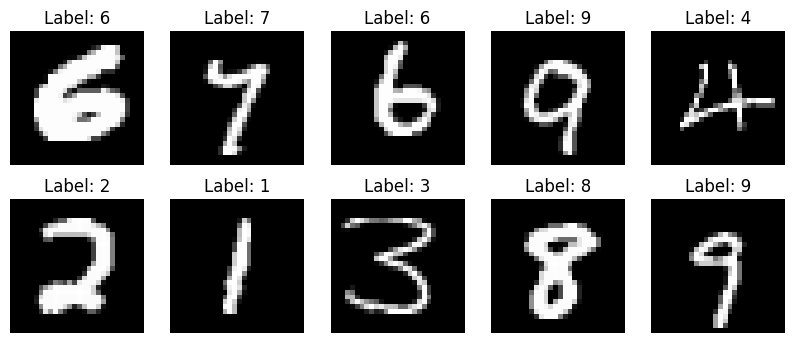

In [20]:
import matplotlib.pyplot as plt

# Pokaż 10 obrazkaów ze zbioru treningowego
fig, axes = plt.subplots(2, 5, figsize=(10, 4))

for i, ax in enumerate(axes.flat):
    img, label = train_dataset[i]
    ax.imshow(img.squeeze(), cmap="gray")
    ax.set_title(f"Label: {label}")
    ax.axis("off")


Dane to obrazki w przestrzeni szarości o rozmiarze 28x28. Mają tylko jeden kanał. Przedstawiają cyfry 0-9.

In [21]:
# Zdefiniuj model w postaci klasy
# Określamy, że klasą nadrzędną(ang. superclass) dla naszej klasy jest nn.Module (więcej info w komentarzu poniżej)
class Net(nn.Module):
    def __init__(self): # zawsze jest w klasie definiującej model
        # Wywołujemy konstruktor superklasy dla klasy Net - jeśli nasza klasa nazywałaby się inaczej to tutaj też musimy zmienić
        super(Net, self).__init__()

        # W konstruktorze klasy modelu definiujemy elementy składowe sieci neuronowej wraz z ich parametrami

        # nn.Linear to określająca wartwę liniową (nie zawiera funkcji aktywacji)
        # zwaną także fully-connected (w skrócie 'fc'), w pełni połączoną, gęstą, MLP
        # pierwszy parametr określa liczbę neuronów wejściowych a drugi liczbę neuronów wyjściowych
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)


    def forward(self, x):      # ta metoda zawsze powinna tak się nazywa (jest odpowiedzialna za wykonanie inferencji)

       # Określamy w jakiej kolejności dane wejściowe do modelu mają przechodzić przez komponenty sieci neuronowej
        x = x.view(-1, 28*28)               # Transformacja obrazu do wektora, bo warstwy MLP przyjmują wektory a nie macierze 2D (obrazki)
        x = torch.relu(self.fc1(x))         # Dodajemy nieliniową funkcję aktywacji ReLU
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)                     # Zauważ, że w finalnej warstwie nie używamy funkcji aktywacji - w przypadku klasyfikacji cyfr powinniśmy użyć funkcji softmax
                                            # Nie robimy tego jednak, bo jest ona już uwzględniona w definicji funkcji kosztu zwanej entropią krzyżową (Cross Entropy)
        return x

Każda własna sieć w PyTorch powinna dziedziczyć po `nn.Module` bo to `nn.Module` robi całą „magię” związaną z działaniem sieci neuronowej: rejestruje parametry (żeby optymalizator mógł je aktualizować), pozwala wywoływać model jak funkcję poprzez `forward()` i integruje się z `autograd`.
Daje też wygodne funkcje jak `train()`, `eval()`, `to()`, `state_dict()`.
Dziedziczenie polega na tym, że w danej klasie możemy korzystać z metod zdefiniowanych w klasie nadrzędnej.

*Jak inicjalizowane są wagi warstw liniowych?
Są to wartości losowe z rozkładów jednostajnych o przedziałach uzależnionych od liczby elementów danych wchodzących do sieci.


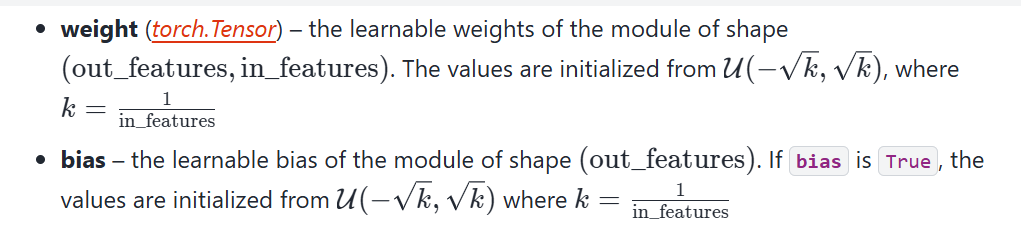

źródło: https://docs.pytorch.org/docs/stable/generated/torch.nn.Linear.html

*jest to temat bardziej zaawansowany (jego zrozumienie nie jest konieczne w perspektywy dalszych treści)

### Pętla treningowa z mechanizmem Early stopping

In [26]:
# Inicjalizacja obiektu sieci neuronowej oraz funkcji straty i optymalizatora
model = Net().to(device)
criterion = nn.CrossEntropyLoss()   # funkcja kosztu w postaci entropii krzyżowej (w implementacji tej funkcji uwzględniona jest już funkcja softmax dlatego nie ma jej w definicji modelu Net)
optimizer = optim.AdamW(model.parameters(), lr=0.001) #lr to learning_rate odpowiadający za "szybkość uczenia się" poprzez wpływ na rozmiar stosowanych zmian w celu aktualizacji wag
                                                      # na zajęciach omawiany był najprostszy optymalizator (SGD) a tutaj jest użyty inny (jest wiele różnych do wyboru), AdamW należy do jednych z najpopularniejszych
max_epochs = 50

# Early stopping - potrzebne zmienne
patience = 3                     # liczba epok ile czekamy na poprawę modelu
best_val_loss = float('inf')     # trening polega na minimalizowaniu błędu modelu więc na początku zakładamy, że jest nieskończonością
patience_counter = 0             # licznik pokazujący ile epok już czekamy na poprawę

In [22]:
# Stworzenie list, w których magazynować będziemy wartości dot. progresu w trakcie treningu
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Pętla treningowa z mechanizmem Early Stopping
for epoch in range(max_epochs):
    model.train()                                                 # ustawiamy model w tryb trenowania - wtedy takie warstwy jak Dropout i Batch Normalization zachowują się inaczej niż podczas ewaluacji
    train_loss = 0
    correct_train = 0
    total_train = 0

    for data, target in train_loader:                             # iterujemy po zbiorze treningowym - zwracane są paczki o rozmiarze batch_size
        data, target = data.to(device), target.to(device)         # przenosimy dane na odpowiednie urządzenie - ważne jest, aby wagi modelu i dane były na tym samym urządzeniu

        optimizer.zero_grad()                                     # zerujemy gradienty w ramach optymalizatora (robimy tak przed analizą każdego batch'a treningowego, aby gradienty się nie akumulowały)
        output = model(data)                                      # wykonujemy inferencję modelu
        loss = criterion(output, target)                          # wyliczamy funkcję kosztu (błąd modelu)
        loss.backward()                                           # obliczamy gradient funkcji kosztu względem wag modelu
        optimizer.step()                                          # dokonujemy aktualizacji wag zgodnie z mechanizmem zaimplementowanym w optymalizatorze

        train_loss += loss.item()
        _, predicted_train = torch.max(output.data, 1)
        total_train += target.size(0)
        correct_train += (predicted_train == target).sum().item()

    train_loss_avg = train_loss/len(train_loader)
    train_accuracy = 100 * correct_train / total_train
    train_losses.append(train_loss_avg)
    train_accuracies.append(train_accuracy)

    # Walidacja modelu                                            # przełączamy model w tryb walidacji
    model.eval()
    val_loss = 0
    correct_val = 0
    total_val = 0
    with torch.no_grad():                                         # w trakcie ewaluacji nie potrzebujemy korzystać z gradientów, bo nie aktualizujemy wag - chcemy tylko zbadać zdolność modelu do generalizacji
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            val_loss += loss.item()
            _, predicted_val = torch.max(output.data, 1)
            total_val += target.size(0)
            correct_val += (predicted_val == target).sum().item()

    val_loss_avg = val_loss/len(val_loader)
    val_accuracy = 100 * correct_val / total_val
    val_losses.append(val_loss_avg)
    val_accuracies.append(val_accuracy)

    print(f'Epoch {epoch+1}, Training Loss: {train_loss_avg:.4f}, Training Accuracy: {train_accuracy:.2f}%, Validation Loss: {val_loss_avg:.4f}, Validation Accuracy: {val_accuracy:.2f}%')

    # Sprawdzamy czy model się poprawił czyli czy zmieniejszył się błąd na zbiorze walidacyjnym
    # jeżeli błąd się zmniejszył to przypisujemy do go zmiennej best_val_loss i aktualne zapisujemy wagi modelu
    if val_loss_avg < best_val_loss:
        best_val_loss = val_loss_avg
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model.pth')  # Save the best model

    # jeżeli błąd się nie zmniejszył to zwiększamy nasz licznik epok, kiedy model się nie poprawił
    else:
        patience_counter += 1

    # warunek Early stopping: jeżeli czekamy na poprawę modelu dłużej niż parametr patience to kończymy trening
    if patience_counter >= patience:
        print(f"Early stopping at epoch {epoch+1}")
        break

# wczytujemy najlepszy model (gdy validation loss był najniższy)
model.load_state_dict(torch.load('best_model.pth'));

Epoch 1, Training Loss: 0.4125, Training Accuracy: 87.73%, Validation Loss: 0.2778, Validation Accuracy: 91.78%
Epoch 2, Training Loss: 0.2061, Training Accuracy: 93.69%, Validation Loss: 0.1824, Validation Accuracy: 94.45%
Epoch 3, Training Loss: 0.1490, Training Accuracy: 95.49%, Validation Loss: 0.1687, Validation Accuracy: 94.93%
Epoch 4, Training Loss: 0.1220, Training Accuracy: 96.24%, Validation Loss: 0.1348, Validation Accuracy: 95.98%
Epoch 5, Training Loss: 0.1017, Training Accuracy: 96.80%, Validation Loss: 0.1247, Validation Accuracy: 96.33%
Epoch 6, Training Loss: 0.0871, Training Accuracy: 97.31%, Validation Loss: 0.1159, Validation Accuracy: 96.62%
Epoch 7, Training Loss: 0.0782, Training Accuracy: 97.51%, Validation Loss: 0.1192, Validation Accuracy: 96.59%
Epoch 8, Training Loss: 0.0665, Training Accuracy: 97.86%, Validation Loss: 0.1272, Validation Accuracy: 96.22%
Epoch 9, Training Loss: 0.0610, Training Accuracy: 98.04%, Validation Loss: 0.1212, Validation Accuracy:

Trening zakończył się wcześniej niż to określał parametr `max_epochs`, bo zadziałał mechanizm Early stopping. Najniższy błąd na zbiorze walidacyjnym był w epoce nr 6 ale potem czekaliśmy 3 epoki na poprawę (parametr `patience`).

### Finalna ewaluacja modelu na zbiorze testowym - wykonywana tylko raz gdy finalny model został już wybrany

In [23]:
model.eval()
correct_test = 0
total_test = 0
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        outputs = model(data)
        _, predicted = torch.max(outputs.data, 1)
        total_test += target.size(0)
        correct_test += (predicted == target).sum().item()

test_accuracy = 100 * correct_test / total_test  # wyliczamy miarę dokładności modelu (accuracy)
print(f'Test Accuracy: {test_accuracy:.2f}%')


Test Accuracy: 96.86%


### Wykresy straty i dokładności (loss and accuracy)

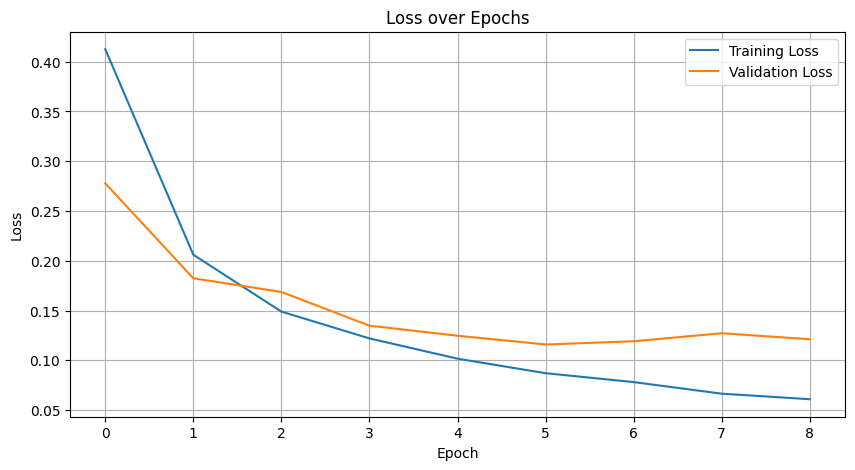

In [24]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

*Zastanów się dlaczego może tak się zdażyć, że błąd na zbiorze walidacyjnym w pierwszej epoce (tutaj oznaczonej jako zerowa) jest mniejszy niż na zbiorze treningowym?

*odpowiedź na to pytanie nie jest konieczna, aby zrozumieć kolejne treści

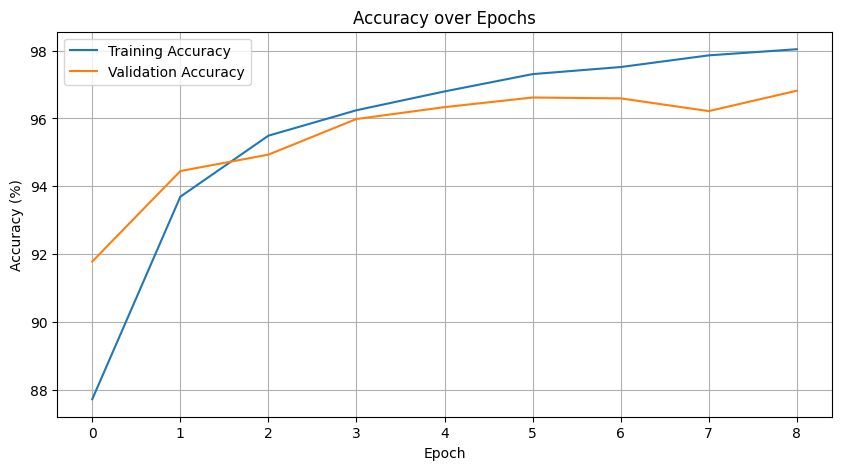

In [25]:
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.show()